In [1]:
from itertools import product
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

%matplotlib inline

In [2]:
from encoders import CatEncoder, OneHotEncoder
from knn import get_knn_model
from metrics import f1_score_metric

In [3]:
!wget "https://www.openml.org/data/get_csv/18116966/php2jDIhh"

--2020-11-06 09:50:43--  https://www.openml.org/data/get_csv/18116966/php2jDIhh
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘php2jDIhh.1’

php2jDIhh.1             [ <=>                ]  74,34K  --.-KB/s    in 0,07s   

2020-11-06 09:50:44 (1,02 MB/s) - ‘php2jDIhh.1’ saved [76122]



In [3]:
dataset_df = pd.read_csv("php2jDIhh")
dataset_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
dataset_df.shape

(1728, 7)

In [5]:
vectorized = CatEncoder().fit(dataset_df).transform(dataset_df)

In [6]:
vectorized.shape

(1728, 7)

In [7]:
X, y = vectorized[:, 0:6], vectorized[:, 6]

In [8]:
one_hot_y = OneHotEncoder().fit(y.reshape(-1, 1)).transform(y.reshape(-1, 1))
one_hot_y.shape

(1728, 4)

In [9]:
num_classes = len(one_hot_y[0])

In [11]:
_DISTANCES = ["euclidean", "manhattan", "chebyshev"]
_KERNELS = ["uniform", "triangular", "epanechnikov", "quartic"]
_WINDOW_TYPES = ["fixed", "variable"]
_WINDOW_PARAMS = [i + 1 for i in range(0, int(math.sqrt(len(dataset_df))), 2)]

In [12]:
def get_confusion_matrix(model, X, one_hot_y):
    num_classes = len(one_hot_y[0])
    cm = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    
    for cur_idx in range(len(X)):
        gt_label = np.argmax(one_hot_y[cur_idx])
        target = X[cur_idx]
        
        X_train = np.delete(X, cur_idx, axis=0)
        y_train = np.delete(one_hot_y, cur_idx, axis=0)
        
        model.fit(X_train.tolist(), y_train.tolist())
        predicted_label = model.predict(target.tolist())

        cm[gt_label][predicted_label] += 1
        
    return cm

In [13]:
configs = list(product(_DISTANCES, _KERNELS, _WINDOW_TYPES, _WINDOW_PARAMS))

In [14]:
best_config = None
best_f1_score = -1

In [15]:
for config in tqdm(configs):
    model = get_knn_model(*config)
    cm = get_confusion_matrix(model, X, one_hot_y)
    f1_score = f1_score_metric(num_classes, cm, 'macro')
    
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_config = config

In [18]:
best_config

('euclidean', 'uniform', 'variable', 11)

In [21]:
best_f1_score

0.9662568093441394

In [19]:
f_scores_fixed = []

for h in tqdm(_WINDOW_PARAMS):
    model = get_knn_model(
        best_config[0], best_config[1], best_config[2], h)
    cm = get_confusion_matrix(model, X, one_hot_y)
    f1_score = f1_score_metric(num_classes, cm, 'macro')
    
    f_scores_fixed.append(f1_score)

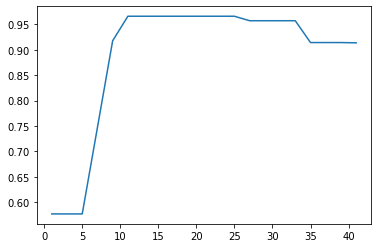

In [22]:
plt.plot(_WINDOW_PARAMS, f_scores_fixed)
plt.show()